In [1]:
%matplotlib inline

# Volumetric Registration and Analysis
In this tutorial we align a CLARITY brain to the Allen Reference Atlas (ARA).  Thus the ARA is our _reference_ image, it consists of image data stored in the default "average" channel and corresponding annotations stored in a separate "annotation" channel.  We begin by importing the relevant modules

In [2]:
from ndreg import *
import matplotlib
import ndio.remote.neurodata as neurodata

## Downloading Atlas
First we'll download the atlas image

In [3]:
refToken = "ara_ccf3"
refImg = imgDownload(refToken) 

Next we'll visuaize the image.  To ensure that the visuization is has good contrast we'll only show intensity values below the 99th percentile.

In [4]:
refThreshold = imgPercentile(refImg, 0.99)
print(refThreshold)

269.129411765


When given an image volume *imgShow* displays it as a set of evenly spaced z-slices (1st column), y-slices (2nd column) and x slices (3rd column).

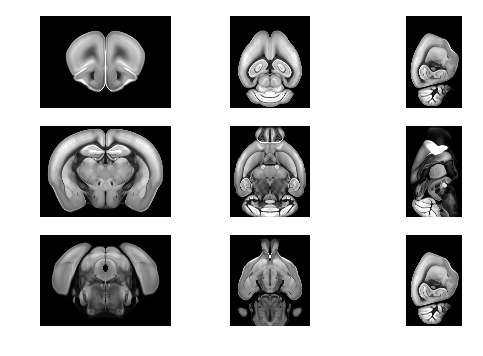

In [5]:
imgShow(refImg, vmax=refThreshold)

## Downloading CLARITY brain
Our *input* image will be the CLARITY brain.  At full resolution, CLARITY brains can be 1 Terabyte in size, far to large to be downloaded to a personal computer.  Thus *ndstore* stores the brains at multiple resolutions. Resolution 0 is always the highest resolution each subsequent resoltion takes up 1/4th (under slice scaling) or 1/8th (under isotropic scaling) as many bytes as the previous resoltion.  Lets look at the resolution of the ARA

In [6]:
print(refImg.GetSpacing())

(0.01, 0.01, 0.01)


It is 0.01 X 0.01 X 0.01 mm (10 x 10 x 10 um).  Therefore we'll want to download the CLARITY brain at a simmilar resolution. We can use ndio's get_metadata method to see a list of available resoltions.  

In [7]:
inToken = "152DLS_tail"
inChannel = "ch0"
nd = neurodata()
resolutionDict = nd.get_metadata(inToken)['dataset']['voxelres']
resolutionList = map(int,resolutionDict.keys())
resolutionList.sort()
for resolution in resolutionList:
    print(resolution, resolutionDict[str(resolution)])

(0, [585.0, 585.0, 5000.0])
(1, [1170.0, 1170.0, 5000.0])
(2, [2340.0, 2340.0, 5000.0])
(3, [4680.0, 4680.0, 5000.0])
(4, [9360.0, 9360.0, 5000.0])
(5, [18720.0, 18720.0, 5000.0])
(6, [37440.0, 37440.0, 5000.0])
(7, [74880.0, 74880.0, 5000.0])
(8, [149760.0, 149760.0, 5000.0])
(9, [299520.0, 299520.0, 5000.0])
(10, [599040.0, 599040.0, 5000.0])


Resolution 4 is 9.36 x 9.36 x 5 um is the closest to what we want.  So we'll download the CLARITY image at that resolution.  Depending on your internet connection downloading may take several minutes.

In [8]:
inImg = imgDownload(inToken, inChannel, resolution=4)

Once again we'll only use intensity values below the 99th percentile in the visualization.

## Reorienting CLARITY image
You may have noticed that the CLARITY brain is not oriented in the same way as the atlas.  Let's look at the atlas.

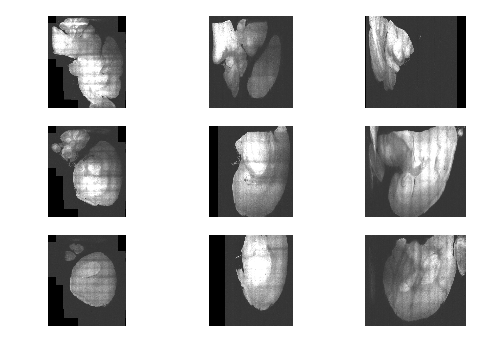

In [9]:
inThreshold = imgPercentile(inImg, 0.99)
imgShow(inImg, vmax=inThreshold)

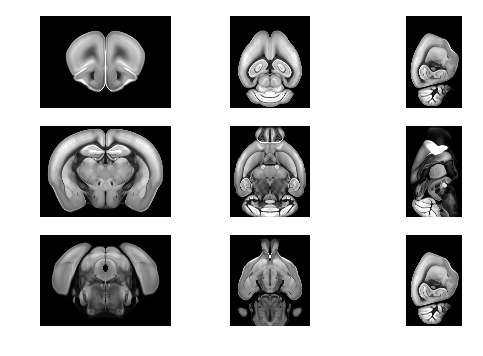

In [10]:
imgShow(refImg, vmax=refThreshold)

By examining the the z slices in the first column its clear that the x-axis goes from **R**ight to Left side of the brain. The y-axis varies from **S**uperior to Inferior and the z-axis goes from **A**nterior to posterior.  Thus it is in **RSA** orientation.  Looking at the the CLARITY brain...

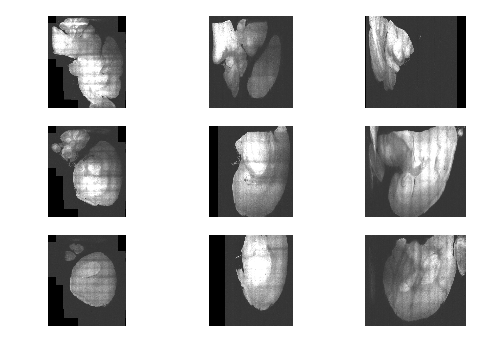

In [11]:
imgShow(inImg, vmax=inThreshold)

...we see that the x-axis goes from **I**nferior to Superior, the y-axis goes from **P**osterior to Anterior and the Z axis goes from **L**eft to Right.  Thus it's in **IPL** orientation.  Therefore we reorient the CLARITY image from **IPL** to **RSA**

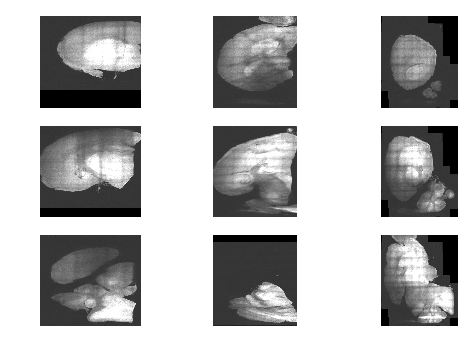

In [12]:
inOrient = "PLI"
refOrient = "RSA"
inImg = imgReorient(inImg, inOrient, refOrient)
imgShow(inImg, vmax=inThreshold)

Compare the above to the Atlas.  The slices should now correspond with the atlas even though in this case we only have half of a CLARITY brain. Let's make a copy of the reorianted image size and spacing because we'll need it later.

In [13]:
inImgSize_reorient = inImg.GetSize()
inImgSpacing_reorient= inImg.GetSpacing()

## Resampling CLARITY image
Notice how the CLARITY brain's resolution is higher than the ARA image that we want to align it to.

In [14]:
print(inImg.GetSpacing())

(0.005, 0.00936, 0.00936)


In [15]:
print(refImg.GetSpacing())

(0.01, 0.01, 0.01)


Since we are aliging the CLARITY image to a lower resolution atlas we resample it to the resolution atlas.

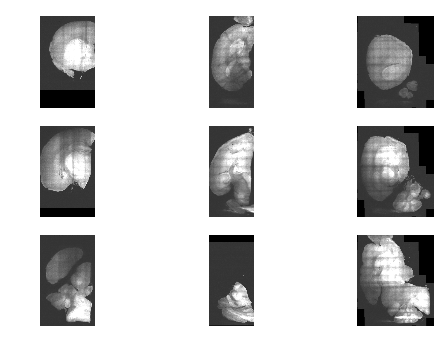

In [16]:
inImg = imgResample(inImg, spacing=refImg.GetSpacing())
imgShow(inImg, vmax=inThreshold)

## Thresholding CLARITY image
Lets plot the histogram of the CLARITY image

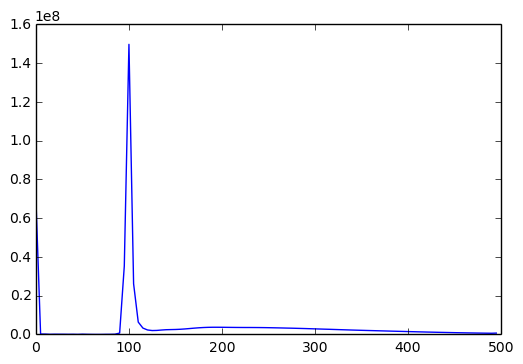

In [17]:
(values, bins) = np.histogram(sitk.GetArrayFromImage(inImg), bins=100, range=(0,500))
plt.plot(bins[:-1], values)

Notice the huge spike at 100.  This occurs because the intensity of the background is about 100. Idealy we want a black background with an intensity of 0.  Therefore we'll threhold the image below 100 and then subtract 100 from the image.  Notice how we've recalculate the visualization threshold "inThreshold" since we've changed the intensity of the input image.

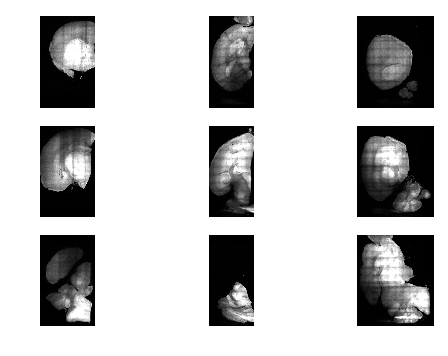

In [18]:
lowerThreshold = 100
upperThreshold = sitk.GetArrayFromImage(inImg).max()+1

inImg = sitk.Threshold(inImg,lowerThreshold,upperThreshold,lowerThreshold) - lowerThreshold
inThreshold -= lowerThreshold

imgShow(inImg, vmax=inThreshold)

Here's a histogram of the result

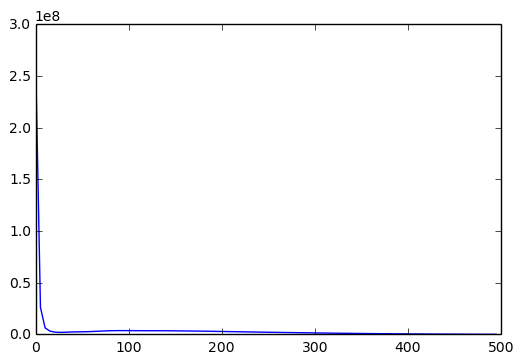

In [19]:
(values, bins) = np.histogram(sitk.GetArrayFromImage(inImg), bins=100, range=(0,500))
plt.plot(bins[:-1], values)

## Generating CLARITY mask
CLARITY brains contain really brignt fluorescent spots in the cerebral cortex and thalamus which can interfer with the registration.

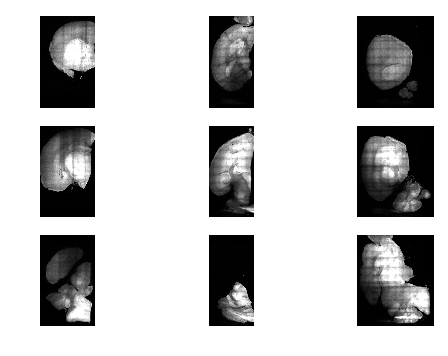

In [20]:
imgShow(inImg, vmax=inThreshold)

To avoid this problem we create a mask which will be used to exclude the top 5% brighest voxels (95th percentile) from registration.

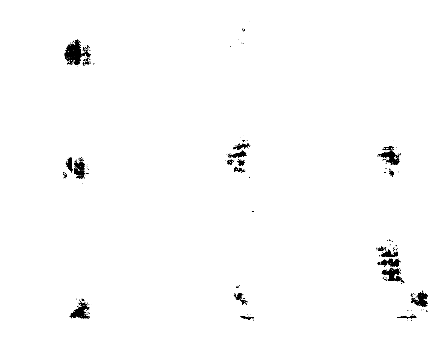

In [21]:
inMask = sitk.BinaryThreshold(inImg, 0, imgPercentile(inImg, 0.95), 1, 0)
imgShow(inMask)

The masked areas will be excluded from the registration

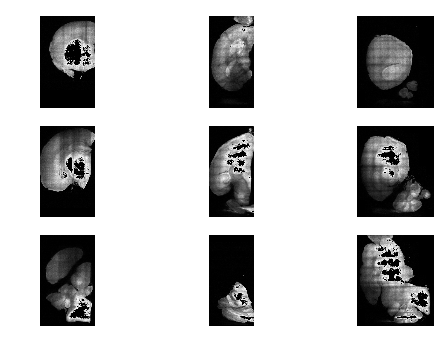

In [22]:
imgShow(imgMask(inImg,inMask))

## Downsample Images
Ideally we would do resgistration at the full atlas scale of 0.01 mm x 0.01 x 0.01 mm but this would be far to computationally expensive for the purposes of this tutorial.  Therefore to save time we downsample the images to 0.1 mm x 0.1mm x 0.1mm

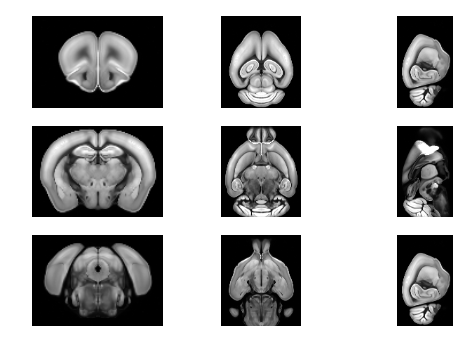

In [23]:
spacing=[0.1,0.1,0.1]
refImg_ds = imgResample(refImg, spacing=spacing)
imgShow(refImg_ds, vmax=refThreshold)

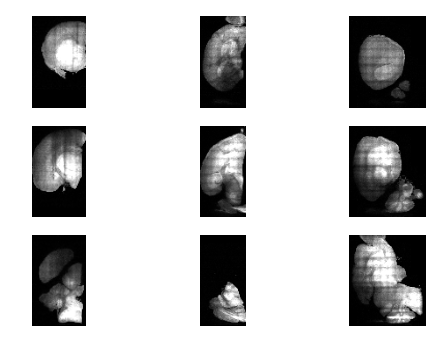

In [24]:
inImg_ds = imgResample(inImg, spacing=spacing)
imgShow(inImg_ds, vmax=inThreshold)

Notice how we use nearest neighbor interpolation when downsampling the mask

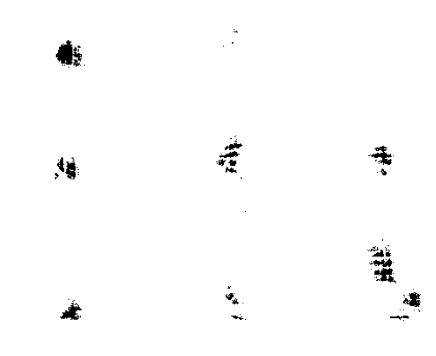

In [25]:
inMask_ds = imgResample(inMask, spacing=spacing, useNearest=True)
imgShow(inMask_ds)

## Generating ARA Mask
Notice how our input image is we only have half of a CLARITY brain.  Therefore we should only use half of the ARA during registration.  To do this we generate a mask of the ARA which excludes half of the brain.

In [26]:
refSize_ds = refImg_ds.GetSize()
refArraySize_ds = np.array(refSize_ds)[::-1]
refMaskArray_ds = np.zeros(refArraySize_ds)
start = refArraySize_ds[-1]/2
refMaskArray_ds[:,:,:start] = 1
refMask_ds = sitk.GetImageFromArray(refMaskArray_ds)
refMask_ds.SetSpacing(spacing)

Thus we'll register the half CLARITY brain to half of the ARA

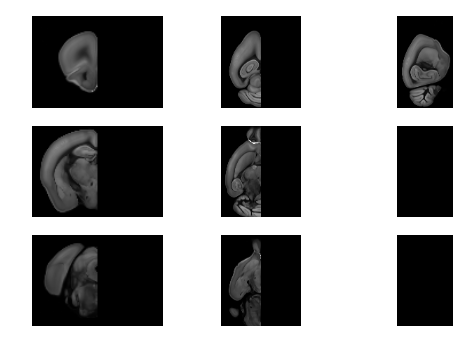

In [27]:
refImg_ds = imgMask(refImg_ds, refMask_ds)
imgShow(refImg_ds)

## Affine Registration
Now we compute the affine transform.  Unlike in the [basic registration tutiorial](basicRegistration.ipynb) we'll use the *imgAffineComposite* instead of *imgAffine*.  *imgAffine* simply computes the affine transform between the input and reference images.  *imgAffineComposite* computes a translation then a rigid then an affine transformation.  It's output is the composition of those three transforms.  We use Mutual Information since the CLARITY and ARA images have very differnt intensity profiles.  We also enable the *verbose* option so that each iteration is printed.

In [28]:
affine = imgAffineComposite(inImg_ds, refImg_ds, inMask=inMask_ds, iterations=200, useMI=True, verbose=True)

Step translation:
0.	 -0.148578663677
1.	 -0.150176712357
2.	 -0.161554969631
3.	 -0.166461116193
4.	 -0.177239170837
5.	 -0.184914960544
6.	 -0.192160128131
7.	 -0.201310363551
8.	 -0.20450724846
9.	 -0.207872956397
10.	 -0.214015699833
11.	 -0.216808755171
12.	 -0.224701872415
13.	 -0.226833854335
14.	 -0.224571053358
15.	 -0.230782374294
16.	 -0.234348539405
17.	 -0.238304106451
18.	 -0.242132381799
19.	 -0.245674092315
20.	 -0.256481862813
21.	 -0.263398116607
22.	 -0.266192741082
23.	 -0.276358343244
24.	 -0.283485732522
25.	 -0.287733473038
26.	 -0.28215055209
27.	 -0.286387891977
28.	 -0.286335726292
29.	 -0.284382342891
30.	 -0.284448823772
31.	 -0.284517971105
32.	 -0.284597754206
33.	 -0.284668306473
34.	 -0.284684769343
Step rigid:
0.	 -0.302139524622
1.	 -0.293776387627
2.	 -0.3158636094
3.	 -0.333686269097
4.	 -0.341763840391
5.	 -0.325495519045
6.	 -0.342136962123
7.	 -0.34318045635
8.	 -0.347614951158
9.	 -0.344926439717
10.	 -0.347759445615
11.	 -0.348786779534
12.	 -0.

Now we apply the affine transform to the input CLARITY image and mask

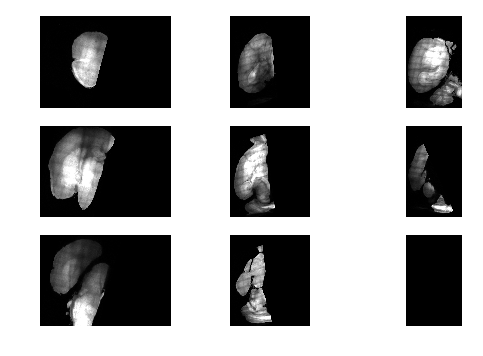

In [29]:
inImg = imgApplyAffine(inImg, affine, size=refImg.GetSize())
imgShow(inImg, vmax=inThreshold)
inMask = imgApplyAffine(inMask, affine, size=refImg.GetSize(), useNearest=True)

## LDDMM registration
Now we run LDDMM registration. Here we use *imgMetamorphosisComposite*.  Unlike *imgMetamorphosis* introduced in the [2D registration notebook](2D_Registration.ipynb), this function runs LDDMM in multiple steps using the alpha values specified by in *alphaList*. The *field* and *invField* outputs are the composition of all steps.  Once agan we use a Mutual Information cost because the input CLARITY brain and reference ARA average have very differnt intensity profiles.


Step 0: alpha=0.05, beta=0.05, scale=0.25
	E, E_velocity, E_rate, E_image (E_image %), LearningRate
0.	-1.16129e+10, 1.78662, 0, -1.16129e+10 (99.8067%), 8.593750e-06
1.	-1.16278e+10, 2.40146, 0, -1.16278e+10 (99.7827%), 4.726563e-06
2.	-1.16576e+10, 2.80552, 0, -1.16576e+10 (99.7345%), 2.599609e-06
E = -1.16576e+10 (99.7345%)
Length = 3.07843
Time = 17.145s (0.28575m)

Step 1: alpha=0.02, beta=0.05, scale=0.5
	E, E_velocity, E_rate, E_image (E_image %), LearningRate
0.	-7.94059e+09, 91.7688, 0, -7.94059e+09 (99.085%), 1.100000e-03
1.	-8.66176e+09, 168.466, 0, -8.66176e+09 (97.9645%), 1.210000e-03
2.	-8.73233e+09, 334.809, 0, -8.73233e+09 (97.8549%), 1.331000e-03
3.	-9.48729e+09, 424.939, 0, -9.48729e+09 (96.6819%), 7.320500e-04
4.	-9.67408e+09, 495.052, 0, -9.67408e+09 (96.3916%), 8.052550e-04
5.	-1.00732e+10, 552.121, 0, -1.00732e+10 (95.7715%), 4.428903e-04
6.	-1.02848e+10, 603.118, 0, -1.02848e+10 (95.4427%), 4.871793e-04
7.	-1.04732e+10, 674.162, 0, -1.04732e+10 (95.1501%), 5.358

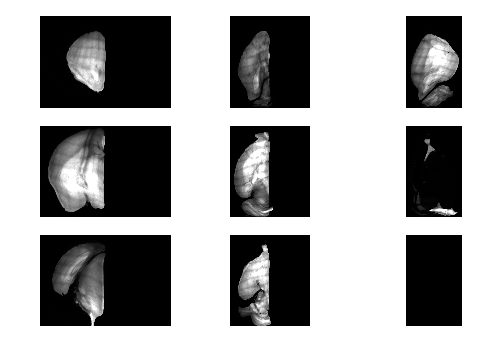

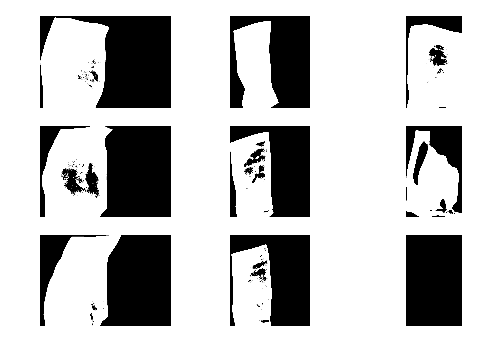

In [30]:
inImg_ds = imgResample(inImg, spacing=spacing)
inMask_ds = imgResample(inMask, spacing=spacing, useNearest=True)
(field, invField) = imgMetamorphosisComposite(inImg_ds, refImg_ds, inMask=inMask_ds, alphaList=[0.05, 0.02, 0.01], scaleList = [0.25, 0.5, 1.0], useMI=True, iterations=100, verbose=True)
inImg = imgApplyField(inImg, field, size=refImg.GetSize())
inMask = imgApplyField(inMask, field, size=refImg.GetSize(), useNearest=True)
imgShow(inImg, vmax=inThreshold)
imgShow(inMask)

## Evaluating the registration
### Evaluation using checker board
We can evaluate the registration by generating a checkerboard of the deformed CLARITY and ARA.  In this method the input image is placed on the black squares of the metaphorical checkerboard while the reference image is placed on the red squares.  Idealy anatomical sturctures should line up across squares.

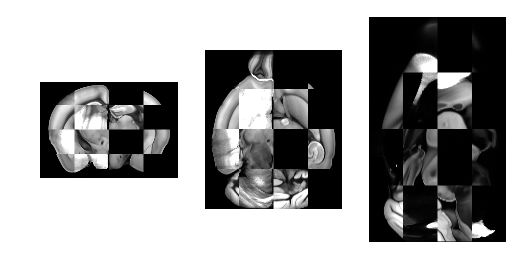

In [31]:
imgShow(imgChecker(inImg, refImg, useHM=False), vmax=refThreshold, numSlices=1)

## Uploading Results

### Uploading deformed CLARITY image
We can now upload the ARA-aligned CLARITY brain back into ndstore.

In [32]:
token = "152DLS_tail_to_ara3"
imgUpload(inImg, token)

### Uploading deformed ARA annotations

To save memory we clear the reference image since it's no longer needed.

In [ ]:
refImg = None

Now we download the ARA annotations

In [ ]:
refAnnoImg = imgDownload(refToken, channel="annotation")

In [ ]:
spacing_ds = invField.GetSpacing()
size_ds = np.ceil(np.array(refAnnoImg.GetSize())*np.array(refAnnoImg.GetSpacing())/np.array(spacing_ds))
size_ds = list(size_ds.astype(int))

Before we can overlay the ARA annotations on the downloaded image we must transfom them to its space. Fortunatly this can be done since all spatial transforms in this tutorial are invertable.  First we construct an inverse displacement field which transforms the annotations from the ARA space to the space before registration.

In [ ]:
invAffine = affineInverse(affine)
invAffineField = affineToField(invAffine, size_ds, spacing_ds)
invField2 = fieldApplyField(invAffineField, invField)
inAnnoImg = imgApplyField(refAnnoImg, invField2,useNearest=True, size=inImgSize_reorient, spacing=inImgSpacing_reorient)
inAnnoThreshold = imgPercentile(inAnnoImg,0.99)
imgShow(inAnnoImg, vmax=inAnnoThreshold)

Were not done yet.  We still need to reorient these annotations from **RSA** to **RPS** 

In [ ]:
inAnnoImg = imgReorient(inAnnoImg, refOrient, inOrient)
imgShow(inAnnoImg, vmax=inAnnoThreshold)

We can upload these annotations at the lowest possible resolution.

In [ ]:
outToken = "ara3_to_152DLS_tail"
outChannel = "annotation_draft"
imgUpload(inAnnoImg, outToken, outChannel, resolution=5)